### Logistic Regression

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import warnings
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
import seaborn as sn
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.feature_selection import RFE

warnings.filterwarnings('ignore')

In [2]:
results = pd.DataFrame(columns=["data", "regularization", "package", "accuracy", "precision", "recall", "f1", "rSquared", "AUC"])  # store results

hcc_median = pd.read_csv('../data/external/median.csv')
hcc_mean = pd.read_csv('../data/external/mean.csv')
hcc_mode = pd.read_csv('../data/external/mode.csv')
hcc_iterative = pd.read_csv('../data/external/iterative.csv')

In [3]:
def get_data(data_name):
    
    if data_name == 'median':
        data = hcc_median
    elif data_name == 'mean':
        data = hcc_mean
    elif data_name == 'mode':
        data = hcc_mode
    else:
         data = hcc_iterative
            
    
    X = data.drop(['Class'], axis=1) # get independent variable
    y = data['Class'] # get dependent variable
    
    # split data 70% to 30%
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=0)
    
    return X_train, X_test, y_train, y_test

#### Feature Selection using Recursive Feature Elimination(RFE)

In [4]:
def feature_selection(X_train, X_test, y_train):
    model = LogisticRegression()

    #rfe = RFECV(estimator=model, step=1, cv=7)
    rfe = RFE(estimator=model, n_features_to_select = 35, step=1)

    rfe = rfe.fit(X_train, y_train)

    columns = X_train.columns[rfe.support_]

    X_train = rfe.transform(X_train)
    X_test = rfe.transform(X_test)

    X_train = pd.DataFrame(X_train, columns = columns)
    X_test = pd.DataFrame(X_test, columns = columns)
    
    return X_train, X_test, y_train

###  
### Using StatsModels



MEAN  IMPUTED DATASET
Optimization terminated successfully.
         Current function value: 0.228057
         Iterations 10
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                  115
Model:                          Logit   Df Residuals:                       80
Method:                           MLE   Df Model:                           34
Date:                Mon, 26 Oct 2020   Pseudo R-squ.:                  0.6525
Time:                        10:50:12   Log-Likelihood:                -26.227
converged:                       True   LL-Null:                       -75.482
Covariance Type:            nonrobust   LLR p-value:                 3.406e-08
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Gender                             3.6851  

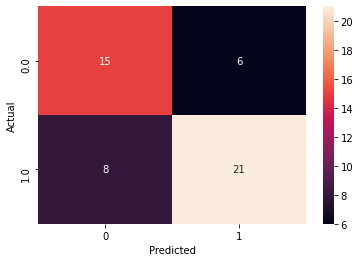



MODE  IMPUTED DATASET
Optimization terminated successfully.
         Current function value: 0.169424
         Iterations 12
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                  115
Model:                          Logit   Df Residuals:                       80
Method:                           MLE   Df Model:                           34
Date:                Mon, 26 Oct 2020   Pseudo R-squ.:                  0.7419
Time:                        10:50:12   Log-Likelihood:                -19.484
converged:                       True   LL-Null:                       -75.482
Covariance Type:            nonrobust   LLR p-value:                 2.969e-10
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Unnamed: 0                        -0.0565  

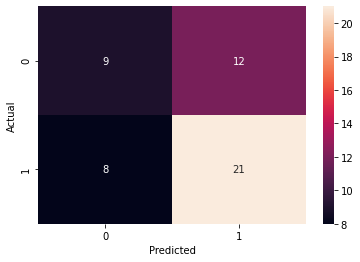



MEDIAN  IMPUTED DATASET
Optimization terminated successfully.
         Current function value: 0.229439
         Iterations 10
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                  115
Model:                          Logit   Df Residuals:                       80
Method:                           MLE   Df Model:                           34
Date:                Mon, 26 Oct 2020   Pseudo R-squ.:                  0.6504
Time:                        10:50:13   Log-Likelihood:                -26.385
converged:                       True   LL-Null:                       -75.482
Covariance Type:            nonrobust   LLR p-value:                 3.797e-08
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Gender                             3.5196

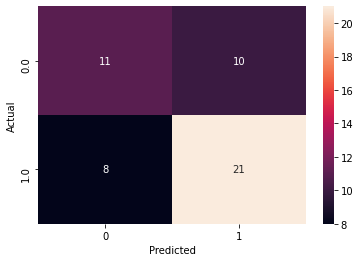



ITERATIVE  IMPUTED DATASET
Optimization terminated successfully.
         Current function value: 0.208838
         Iterations 11
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                  115
Model:                          Logit   Df Residuals:                       80
Method:                           MLE   Df Model:                           34
Date:                Mon, 26 Oct 2020   Pseudo R-squ.:                  0.6818
Time:                        10:50:13   Log-Likelihood:                -24.016
converged:                       True   LL-Null:                       -75.482
Covariance Type:            nonrobust   LLR p-value:                 7.399e-09
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Gender                             4.9

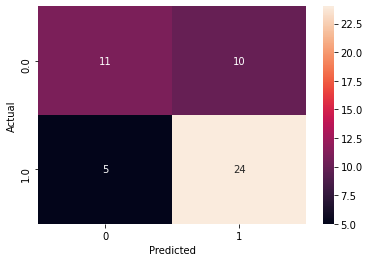

In [5]:
data_list = ['mean', 'mode', 'median', 'iterative']

for data in data_list:
    
    X_train, X_test, y_train, y_test = get_data(data)
    
    X_train, X_test, y_train = feature_selection(X_train, X_test, y_train)
    
    print('\n')
    print(data.upper(), ' IMPUTED DATASET')
    
    ## run logistic regression using stat models
    logistic_sm = sm.Logit(y_train.values.reshape(-1,1), X_train).fit()
    print(logistic_sm.summary())

    y_pred = logistic_sm.predict(X_test) 
    y_pred = (y_pred >= 0.5).astype(int).to_numpy()
    
    print("Accuracy ({}): {:.2f}".format(data, metrics.accuracy_score(y_test, y_pred)))
    print("Precision ({}): {:.2f}".format(data, metrics.precision_score(y_test, y_pred)))
    print("Recall ({}): {:.2f}".format(data, metrics.recall_score(y_test, y_pred)))

    confusion_matrix = pd.crosstab(y_test, y_pred, rownames=['Actual'], colnames=['Predicted'])
    sn.heatmap(confusion_matrix, annot=True)
    plt.show()
    
    ## save data for comparison
    results = results.append(pd.DataFrame([{"data" : data, 
                    "regularization": "default", 
                    "package": "StatsModels", 
                    "accuracy": np.round(metrics.accuracy_score(y_test, y_pred), 2), 
                    "precision": np.round(metrics.precision_score(y_test, y_pred), 2), 
                    "recall": np.round(metrics.recall_score(y_test, y_pred), 2), 
                    "f1": np.round(metrics.f1_score(y_test, y_pred), 2), 
                    "rSquared": np.round(logistic_sm.prsquared, 2), 
                    "AUC": np.round(metrics.roc_auc_score(y_test, y_pred), 2)}]), ignore_index=True)

###  
### Using ScikitLearn



MEAN  IMPUTED DATASET
                                    coef  exp_coef
intercept                      -0.074714  0.928009
Gender                          0.446752  1.563227
Symptoms                       -0.611825  0.542360
Alcohol                         0.397729  1.488441
Hepatitis B Surface Antigen     0.536818  1.710556
Hepatitis B Core Antibody       0.212726  1.237045
Hepatitis C Virus Antibody     -0.498234  0.607603
Cirrhosis                      -0.090431  0.913537
Endemic Countries               0.211252  1.235223
Smoking                         0.393456  1.482094
Diabetes                       -0.562029  0.570051
Obesity                         0.173209  1.189114
Arterial Hypertension           0.830066  2.293471
Chronic Renal Insufficiency    -0.135982  0.872858
Nonalcoholic Steatohepatitis    0.064216  1.066323
Esophageal Varices             -0.157238  0.854501
Splenomegaly                   -0.078168  0.924809
Portal Vein Thrombosis         -0.322067  0.724650
Liver M

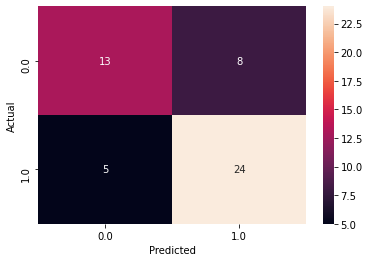

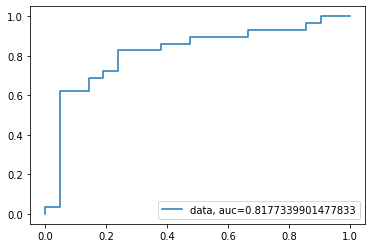



MODE  IMPUTED DATASET
                                    coef  exp_coef
intercept                      -0.092466  0.911680
Unnamed: 0                     -0.009622  0.990424
Gender                          0.473544  1.605674
Symptoms                       -0.368427  0.691822
Alcohol                         0.425094  1.529735
Hepatitis B Surface Antigen     0.671941  1.958035
Hepatitis B Core Antibody       0.398699  1.489885
Hepatitis C Virus Antibody     -0.578350  0.560823
Cirrhosis                      -0.081513  0.921721
Endemic Countries               0.121043  1.128674
Smoking                         0.371580  1.450024
Diabetes                       -0.770169  0.462935
Obesity                         0.260037  1.296978
Arterial Hypertension           0.912358  2.490189
Chronic Renal Insufficiency    -0.177037  0.837749
Nonalcoholic Steatohepatitis    0.054499  1.056011
Esophageal Varices             -0.267676  0.765156
Portal Hypertension             0.605608  1.832366
Portal 

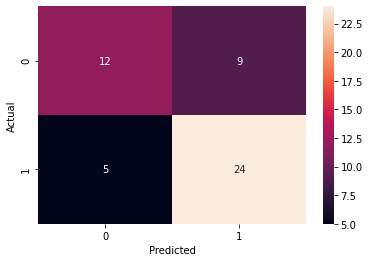

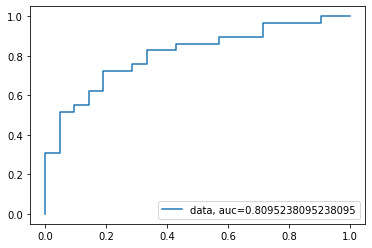



MEDIAN  IMPUTED DATASET
                                    coef  exp_coef
intercept                      -0.070829  0.931621
Gender                          0.663469  1.941515
Symptoms                       -0.492365  0.611179
Alcohol                         0.624971  1.868193
Hepatitis B Surface Antigen     0.806116  2.239195
Hepatitis B Core Antibody       0.498925  1.646950
Hepatitis C Virus Antibody     -0.678249  0.507505
Cirrhosis                      -0.102870  0.902245
Endemic Countries               0.202166  1.224051
Smoking                         0.502269  1.652466
Diabetes                       -0.957486  0.383857
Obesity                         0.244052  1.276411
Arterial Hypertension           1.210407  3.354850
Chronic Renal Insufficiency    -0.188749  0.827994
Nonalcoholic Steatohepatitis    0.050621  1.051924
Esophageal Varices             -0.357969  0.699095
Splenomegaly                    0.089218  1.093320
Portal Vein Thrombosis         -0.220710  0.801949
Liver

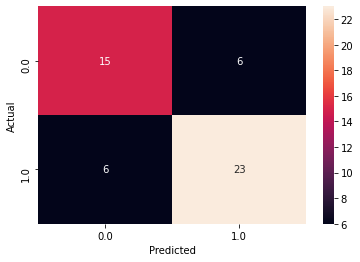

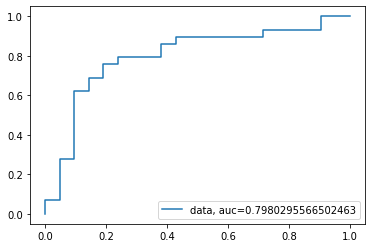



ITERATIVE  IMPUTED DATASET
                                    coef  exp_coef
intercept                      -0.083747  0.919664
Gender                          0.463724  1.589985
Symptoms                       -0.745243  0.474619
Hepatitis B Surface Antigen     0.630899  1.879300
Hepatitis B Core Antibody       0.136532  1.146292
Hepatitis C Virus Antibody     -0.652422  0.520783
Endemic Countries               0.260986  1.298210
Smoking                         0.302081  1.352671
Diabetes                       -0.560962  0.570660
Obesity                         0.262935  1.300743
Arterial Hypertension           1.025511  2.788521
Chronic Renal Insufficiency    -0.082600  0.920719
Nonalcoholic Steatohepatitis    0.033456  1.034022
Esophageal Varices             -0.154889  0.856510
Splenomegaly                   -0.170795  0.842994
Portal Hypertension             0.210786  1.234648
Portal Vein Thrombosis         -0.356382  0.700205
Liver Metastasis               -0.339420  0.712183
Ag

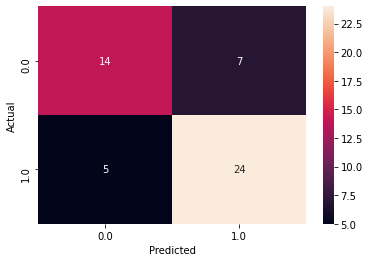

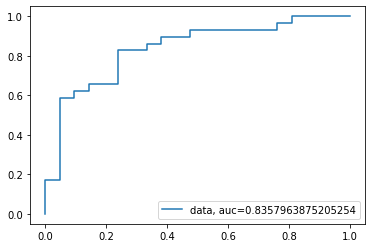

In [6]:
data_list = ['mean', 'mode', 'median', 'iterative']

for data in data_list:
    
    X_train, X_test, y_train, y_test = get_data(data)
    
    X_train, X_test, y_train = feature_selection(X_train, X_test, y_train)
    
    print('\n')
    print(data.upper(), ' IMPUTED DATASET')
    
    ## run logistic regression using sklearn
    logistic = LogisticRegression()
    logistic = logistic.fit(X_train,y_train)
    y_pred = logistic.predict(X_test)
    
    
    # printing
    values = np.append(logistic.intercept_, logistic.coef_)

    # get the names of the values
    names = np.append('intercept', X_train.columns)
    table_ = pd.DataFrame(values, index = names, columns=['coef'])
    table_['exp_coef'] = np.exp(table_['coef'])
    print(table_)
    
    print('\n')
    print("Accuracy ({}): {:.2f}".format(data, metrics.accuracy_score(y_test, y_pred)))
    print("Precision ({}): {:.2f}".format(data, metrics.precision_score(y_test, y_pred)))
    print("Recall ({}): {:.2f}".format(data, metrics.recall_score(y_test, y_pred)))

    confusion_matrix = pd.crosstab(y_test, y_pred, rownames=['Actual'], colnames=['Predicted'])
    sn.heatmap(confusion_matrix, annot=True)
    plt.show()
    
    y_pred_proba = logistic.predict_proba(X_test)[::,1]
    fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
    auc = metrics.roc_auc_score(y_test, y_pred_proba)
    plt.plot(fpr,tpr,label="data, auc="+str(auc))
    plt.legend(loc=4)
    plt.show()
    
    ## save data for comparison
    results = results.append(pd.DataFrame([{"data" : data, 
                    "regularization": "default", 
                    "package": "SkLearn", 
                    "accuracy": np.round(metrics.accuracy_score(y_test, y_pred), 2), 
                    "precision": np.round(metrics.precision_score(y_test, y_pred), 2), 
                    "recall": np.round(metrics.recall_score(y_test, y_pred), 2), 
                    "f1": np.round(metrics.f1_score(y_test, y_pred), 2), 
                    "rSquared": np.round(metrics.r2_score(y_test, y_pred), 2), 
                    "AUC": np.round(metrics.roc_auc_score(y_test, y_pred), 2)}]), ignore_index=True)

## Regularizations

### Using StatsModels



MEAN  IMPUTED DATASET using  Ridge
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.2280574133501607
            Iterations: 210
            Function evaluations: 232
            Gradient evaluations: 210
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                  115
Model:                          Logit   Df Residuals:                       80
Method:                           MLE   Df Model:                           34
Date:                Mon, 26 Oct 2020   Pseudo R-squ.:                  0.6525
Time:                        10:50:16   Log-Likelihood:                -26.227
converged:                       True   LL-Null:                       -75.482
Covariance Type:            nonrobust   LLR p-value:                 3.406e-08
                                     coef    std err          z      P>|z|      [0.025      0.975]
------------------

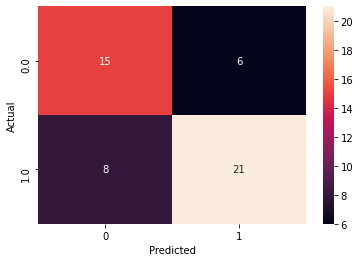



MEAN  IMPUTED DATASET using  Lasso
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.2280574133501607
            Iterations: 210
            Function evaluations: 232
            Gradient evaluations: 210
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                  115
Model:                          Logit   Df Residuals:                       80
Method:                           MLE   Df Model:                           34
Date:                Mon, 26 Oct 2020   Pseudo R-squ.:                  0.6525
Time:                        10:50:16   Log-Likelihood:                -26.227
converged:                       True   LL-Null:                       -75.482
Covariance Type:            nonrobust   LLR p-value:                 3.406e-08
                                     coef    std err          z      P>|z|      [0.025      0.975]
------------------

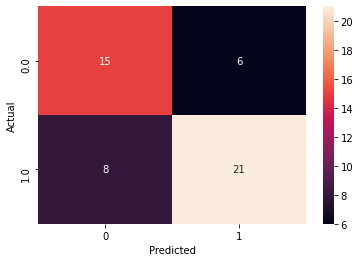



MODE  IMPUTED DATASET using  Ridge
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.16942420633539362
            Iterations: 248
            Function evaluations: 270
            Gradient evaluations: 248
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                  115
Model:                          Logit   Df Residuals:                       80
Method:                           MLE   Df Model:                           34
Date:                Mon, 26 Oct 2020   Pseudo R-squ.:                  0.7419
Time:                        10:50:17   Log-Likelihood:                -19.484
converged:                       True   LL-Null:                       -75.482
Covariance Type:            nonrobust   LLR p-value:                 2.969e-10
                                     coef    std err          z      P>|z|      [0.025      0.975]
-----------------

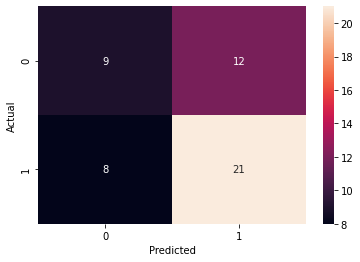



MODE  IMPUTED DATASET using  Lasso
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.16942420633539362
            Iterations: 248
            Function evaluations: 270
            Gradient evaluations: 248
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                  115
Model:                          Logit   Df Residuals:                       80
Method:                           MLE   Df Model:                           34
Date:                Mon, 26 Oct 2020   Pseudo R-squ.:                  0.7419
Time:                        10:50:17   Log-Likelihood:                -19.484
converged:                       True   LL-Null:                       -75.482
Covariance Type:            nonrobust   LLR p-value:                 2.969e-10
                                     coef    std err          z      P>|z|      [0.025      0.975]
-----------------

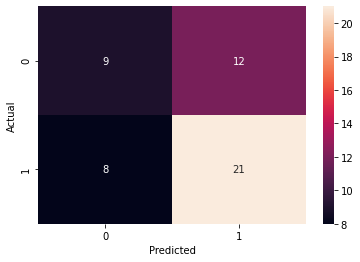



MEDIAN  IMPUTED DATASET using  Ridge
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.2294390718808687
            Iterations: 202
            Function evaluations: 223
            Gradient evaluations: 202
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                  115
Model:                          Logit   Df Residuals:                       80
Method:                           MLE   Df Model:                           34
Date:                Mon, 26 Oct 2020   Pseudo R-squ.:                  0.6504
Time:                        10:50:17   Log-Likelihood:                -26.385
converged:                       True   LL-Null:                       -75.482
Covariance Type:            nonrobust   LLR p-value:                 3.797e-08
                                     coef    std err          z      P>|z|      [0.025      0.975]
----------------

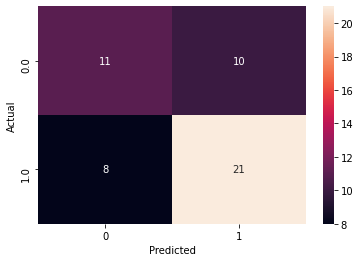



MEDIAN  IMPUTED DATASET using  Lasso
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.2294390718808687
            Iterations: 202
            Function evaluations: 223
            Gradient evaluations: 202
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                  115
Model:                          Logit   Df Residuals:                       80
Method:                           MLE   Df Model:                           34
Date:                Mon, 26 Oct 2020   Pseudo R-squ.:                  0.6504
Time:                        10:50:18   Log-Likelihood:                -26.385
converged:                       True   LL-Null:                       -75.482
Covariance Type:            nonrobust   LLR p-value:                 3.797e-08
                                     coef    std err          z      P>|z|      [0.025      0.975]
----------------

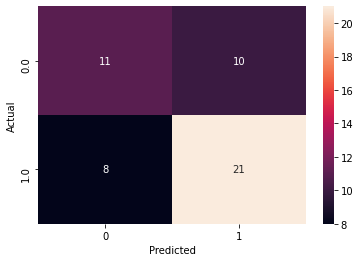



ITERATIVE  IMPUTED DATASET using  Ridge
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.2088381910464242
            Iterations: 221
            Function evaluations: 243
            Gradient evaluations: 221
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                  115
Model:                          Logit   Df Residuals:                       80
Method:                           MLE   Df Model:                           34
Date:                Mon, 26 Oct 2020   Pseudo R-squ.:                  0.6818
Time:                        10:50:18   Log-Likelihood:                -24.016
converged:                       True   LL-Null:                       -75.482
Covariance Type:            nonrobust   LLR p-value:                 7.399e-09
                                     coef    std err          z      P>|z|      [0.025      0.975]
-------------

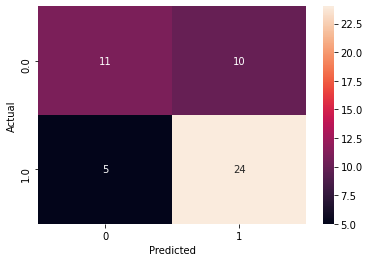



ITERATIVE  IMPUTED DATASET using  Lasso
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.2088381910464242
            Iterations: 221
            Function evaluations: 243
            Gradient evaluations: 221
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                  115
Model:                          Logit   Df Residuals:                       80
Method:                           MLE   Df Model:                           34
Date:                Mon, 26 Oct 2020   Pseudo R-squ.:                  0.6818
Time:                        10:50:19   Log-Likelihood:                -24.016
converged:                       True   LL-Null:                       -75.482
Covariance Type:            nonrobust   LLR p-value:                 7.399e-09
                                     coef    std err          z      P>|z|      [0.025      0.975]
-------------

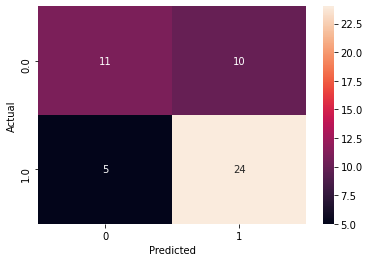

In [7]:
data_list = ['mean', 'mode', 'median', 'iterative']

for data in data_list:
    
    X_train, X_test, y_train, y_test = get_data(data)
    
    X_train, X_test, y_train = feature_selection(X_train, X_test, y_train)
    
    for i in [0, 1]:
        print('\n')
        print(data.upper(), ' IMPUTED DATASET using ', 'Lasso' if i == 1 else 'Ridge')

        ## run logistic regression using stat models
        logistic_sm = sm.Logit(y_train.values.reshape(-1,1), X_train).fit_regularized(L1_wt = i) # if L1_wt = 1, Lasso: 0, Ridge
        print(logistic_sm.summary())

        y_pred = logistic_sm.predict(X_test) 
        y_pred = (y_pred >= 0.5).astype(int).to_numpy()

        print("Accuracy ({}): {:.2f}".format(data, metrics.accuracy_score(y_test, y_pred)))
        print("Precision ({}): {:.2f}".format(data, metrics.precision_score(y_test, y_pred)))
        print("Recall ({}): {:.2f}".format(data, metrics.recall_score(y_test, y_pred)))

        confusion_matrix = pd.crosstab(y_test, y_pred, rownames=['Actual'], colnames=['Predicted'])
        sn.heatmap(confusion_matrix, annot=True)
        plt.show()

        ## save data for comparison
        results = results.append(pd.DataFrame([{"data" : data, 
                        "regularization": 'Lasso' if i == 1 else 'Ridge', 
                        "package": "StatsModels", 
                        "accuracy": np.round(metrics.accuracy_score(y_test, y_pred), 2), 
                        "precision": np.round(metrics.precision_score(y_test, y_pred), 2), 
                        "recall": np.round(metrics.recall_score(y_test, y_pred), 2), 
                        "f1": np.round(metrics.f1_score(y_test, y_pred), 2), 
                        "rSquared": np.round(logistic_sm.prsquared, 2), 
                        "AUC": np.round(metrics.roc_auc_score(y_test, y_pred), 2)}]), ignore_index=True)

#### Using SkLearn



MEAN  IMPUTED DATASET using  Lasso
                                    coef  exp_coef
intercept                       0.000000  1.000000
Gender                          0.465896  1.593441
Symptoms                       -0.860528  0.422939
Alcohol                         0.558165  1.747462
Hepatitis B Surface Antigen     0.122700  1.130545
Hepatitis B Core Antibody       0.000000  1.000000
Hepatitis C Virus Antibody     -0.686037  0.503568
Cirrhosis                       0.000000  1.000000
Endemic Countries               0.304132  1.355448
Smoking                         0.077368  1.080439
Diabetes                       -1.209249  0.298421
Obesity                         0.000000  1.000000
Arterial Hypertension           1.569862  4.805986
Chronic Renal Insufficiency     0.000000  1.000000
Nonalcoholic Steatohepatitis    0.000000  1.000000
Esophageal Varices              0.000000  1.000000
Splenomegaly                    0.000000  1.000000
Portal Vein Thrombosis          0.000000  1.0

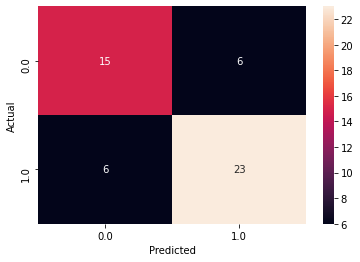

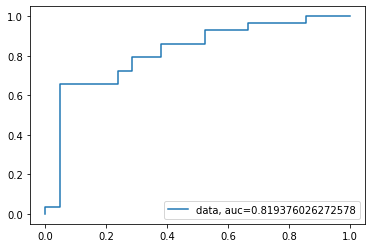



MEAN  IMPUTED DATASET using  Ridge
                                    coef  exp_coef
intercept                      -0.074714  0.928009
Gender                          0.446752  1.563227
Symptoms                       -0.611825  0.542360
Alcohol                         0.397729  1.488441
Hepatitis B Surface Antigen     0.536818  1.710556
Hepatitis B Core Antibody       0.212726  1.237045
Hepatitis C Virus Antibody     -0.498234  0.607603
Cirrhosis                      -0.090431  0.913537
Endemic Countries               0.211252  1.235223
Smoking                         0.393456  1.482094
Diabetes                       -0.562029  0.570051
Obesity                         0.173209  1.189114
Arterial Hypertension           0.830066  2.293471
Chronic Renal Insufficiency    -0.135982  0.872858
Nonalcoholic Steatohepatitis    0.064216  1.066323
Esophageal Varices             -0.157238  0.854501
Splenomegaly                   -0.078168  0.924809
Portal Vein Thrombosis         -0.322067  0.7

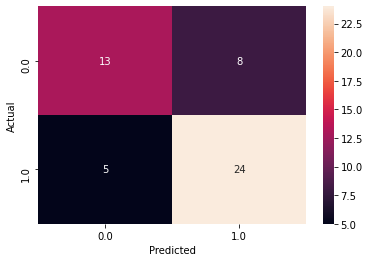

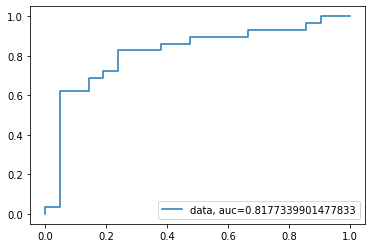



MEAN  IMPUTED DATASET using  ElasticNet
                                    coef  exp_coef
intercept                      -0.000080  0.999920
Gender                          0.000373  1.000373
Symptoms                       -0.002504  0.997499
Alcohol                         0.000525  1.000525
Hepatitis B Surface Antigen     0.000598  1.000598
Hepatitis B Core Antibody       0.000675  1.000675
Hepatitis C Virus Antibody     -0.001166  0.998835
Cirrhosis                       0.000000  1.000000
Endemic Countries               0.000201  1.000201
Smoking                         0.001010  1.001011
Diabetes                       -0.000870  0.999131
Obesity                         0.000719  1.000719
Arterial Hypertension           0.001894  1.001895
Chronic Renal Insufficiency    -0.000225  0.999775
Nonalcoholic Steatohepatitis    0.000000  1.000000
Esophageal Varices             -0.000117  0.999883
Splenomegaly                   -0.000680  0.999320
Portal Vein Thrombosis         -0.000828

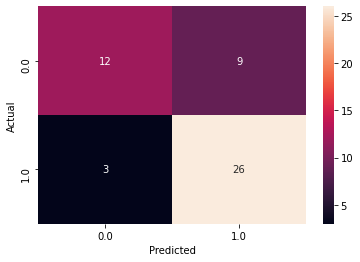

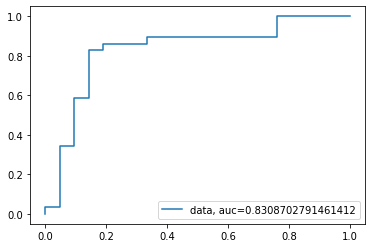



MODE  IMPUTED DATASET using  Lasso
                                    coef  exp_coef
intercept                       0.000000  1.000000
Unnamed: 0                     -0.013152  0.986934
Gender                          0.483202  1.621257
Symptoms                       -0.307428  0.735336
Alcohol                         0.190465  1.209812
Hepatitis B Surface Antigen     0.296993  1.345807
Hepatitis B Core Antibody       0.004326  1.004335
Hepatitis C Virus Antibody     -0.810247  0.444748
Cirrhosis                       0.000000  1.000000
Endemic Countries               0.000000  1.000000
Smoking                         0.000000  1.000000
Diabetes                       -1.268998  0.281113
Obesity                         0.178024  1.194854
Arterial Hypertension           1.602984  4.967832
Chronic Renal Insufficiency     0.000000  1.000000
Nonalcoholic Steatohepatitis    0.000000  1.000000
Esophageal Varices             -0.087889  0.915863
Portal Hypertension             1.165901  3.2

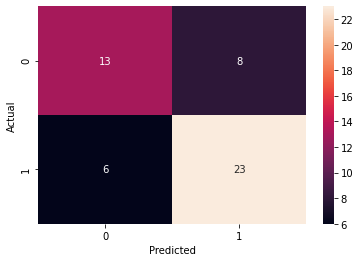

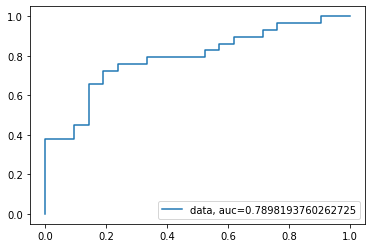



MODE  IMPUTED DATASET using  Ridge
                                    coef  exp_coef
intercept                      -0.092466  0.911680
Unnamed: 0                     -0.009622  0.990424
Gender                          0.473544  1.605674
Symptoms                       -0.368427  0.691822
Alcohol                         0.425094  1.529735
Hepatitis B Surface Antigen     0.671941  1.958035
Hepatitis B Core Antibody       0.398699  1.489885
Hepatitis C Virus Antibody     -0.578350  0.560823
Cirrhosis                      -0.081513  0.921721
Endemic Countries               0.121043  1.128674
Smoking                         0.371580  1.450024
Diabetes                       -0.770169  0.462935
Obesity                         0.260037  1.296978
Arterial Hypertension           0.912358  2.490189
Chronic Renal Insufficiency    -0.177037  0.837749
Nonalcoholic Steatohepatitis    0.054499  1.056011
Esophageal Varices             -0.267676  0.765156
Portal Hypertension             0.605608  1.8

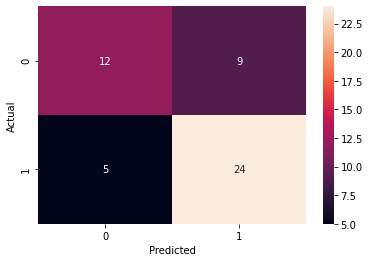

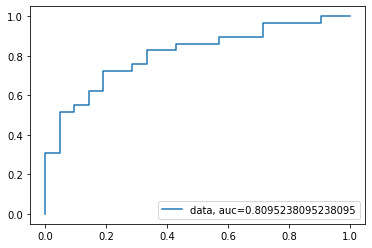



MODE  IMPUTED DATASET using  ElasticNet
                                    coef  exp_coef
intercept                      -0.000029  0.999971
Unnamed: 0                     -0.010304  0.989749
Gender                          0.000367  1.000367
Symptoms                       -0.001451  0.998550
Alcohol                         0.000601  1.000601
Hepatitis B Surface Antigen     0.000523  1.000523
Hepatitis B Core Antibody       0.001122  1.001123
Hepatitis C Virus Antibody     -0.001066  0.998935
Cirrhosis                       0.000000  1.000000
Endemic Countries               0.000000  1.000000
Smoking                         0.000627  1.000627
Diabetes                       -0.001122  0.998879
Obesity                         0.000814  1.000814
Arterial Hypertension           0.001621  1.001623
Chronic Renal Insufficiency    -0.000199  0.999801
Nonalcoholic Steatohepatitis    0.000000  1.000000
Esophageal Varices             -0.000438  0.999562
Portal Hypertension             0.000272

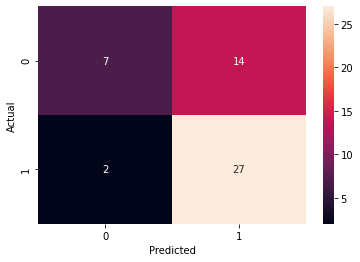

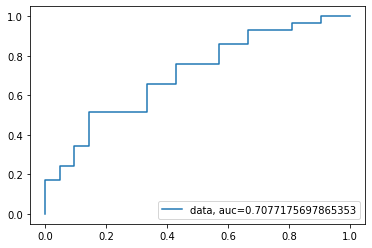



MEDIAN  IMPUTED DATASET using  Lasso
                                    coef  exp_coef
intercept                       0.000000  1.000000
Gender                          0.736858  2.089360
Symptoms                       -0.430363  0.650273
Alcohol                         0.675820  1.965643
Hepatitis B Surface Antigen     0.321501  1.379196
Hepatitis B Core Antibody       0.170225  1.185571
Hepatitis C Virus Antibody     -0.591690  0.553391
Cirrhosis                       0.000000  1.000000
Endemic Countries               0.000000  1.000000
Smoking                         0.015723  1.015847
Diabetes                       -1.183122  0.306321
Obesity                         0.000000  1.000000
Arterial Hypertension           1.634364  5.126196
Chronic Renal Insufficiency     0.000000  1.000000
Nonalcoholic Steatohepatitis    0.000000  1.000000
Esophageal Varices              0.000000  1.000000
Splenomegaly                    0.000000  1.000000
Portal Vein Thrombosis          0.000000  1

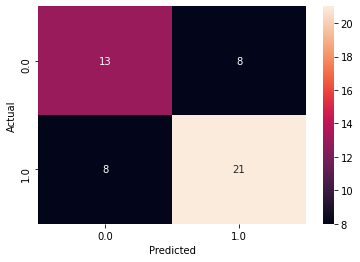

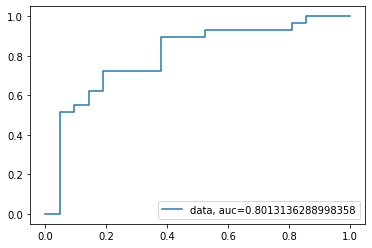



MEDIAN  IMPUTED DATASET using  Ridge
                                    coef  exp_coef
intercept                      -0.070829  0.931621
Gender                          0.663469  1.941515
Symptoms                       -0.492365  0.611179
Alcohol                         0.624971  1.868193
Hepatitis B Surface Antigen     0.806116  2.239195
Hepatitis B Core Antibody       0.498925  1.646950
Hepatitis C Virus Antibody     -0.678249  0.507505
Cirrhosis                      -0.102870  0.902245
Endemic Countries               0.202166  1.224051
Smoking                         0.502269  1.652466
Diabetes                       -0.957486  0.383857
Obesity                         0.244052  1.276411
Arterial Hypertension           1.210407  3.354850
Chronic Renal Insufficiency    -0.188749  0.827994
Nonalcoholic Steatohepatitis    0.050621  1.051924
Esophageal Varices             -0.357969  0.699095
Splenomegaly                    0.089218  1.093320
Portal Vein Thrombosis         -0.220710  0

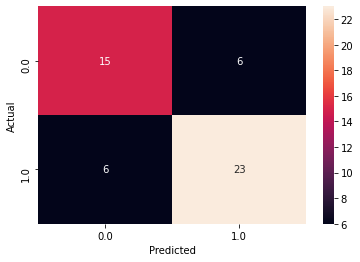

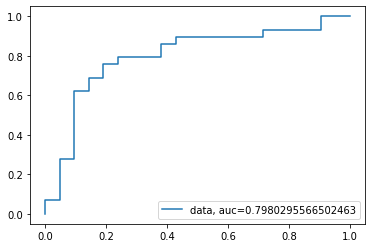



MEDIAN  IMPUTED DATASET using  ElasticNet
                                    coef  exp_coef
intercept                      -0.000093  0.999907
Gender                          0.000448  1.000448
Symptoms                       -0.001925  0.998077
Alcohol                         0.000614  1.000614
Hepatitis B Surface Antigen     0.000714  1.000714
Hepatitis B Core Antibody       0.001037  1.001037
Hepatitis C Virus Antibody     -0.001055  0.998945
Cirrhosis                       0.000000  1.000000
Endemic Countries               0.000127  1.000127
Smoking                         0.000605  1.000606
Diabetes                       -0.000967  0.999033
Obesity                         0.000653  1.000654
Arterial Hypertension           0.001872  1.001874
Chronic Renal Insufficiency    -0.000241  0.999759
Nonalcoholic Steatohepatitis    0.000000  1.000000
Esophageal Varices             -0.000746  0.999255
Splenomegaly                   -0.000359  0.999641
Portal Vein Thrombosis         -0.0008

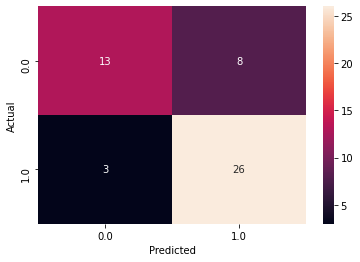

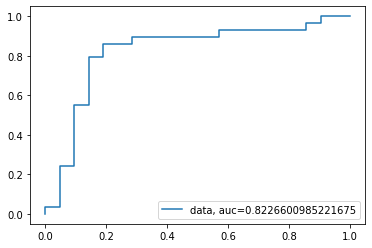



ITERATIVE  IMPUTED DATASET using  Lasso
                                    coef  exp_coef
intercept                       0.000000  1.000000
Gender                          0.606124  1.833311
Symptoms                       -1.080331  0.339483
Hepatitis B Surface Antigen     0.153039  1.165371
Hepatitis B Core Antibody       0.000000  1.000000
Hepatitis C Virus Antibody     -0.729706  0.482051
Endemic Countries               0.147481  1.158911
Smoking                         0.032984  1.033534
Diabetes                       -1.318880  0.267435
Obesity                         0.118810  1.126156
Arterial Hypertension           1.786280  5.967213
Chronic Renal Insufficiency     0.000000  1.000000
Nonalcoholic Steatohepatitis    0.000000  1.000000
Esophageal Varices              0.000000  1.000000
Splenomegaly                    0.000000  1.000000
Portal Hypertension             0.327080  1.386913
Portal Vein Thrombosis          0.000000  1.000000
Liver Metastasis               -0.248658

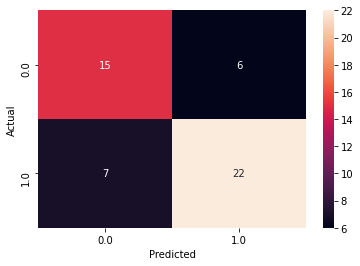

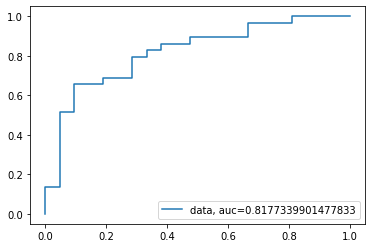



ITERATIVE  IMPUTED DATASET using  Ridge
                                    coef  exp_coef
intercept                      -0.083747  0.919664
Gender                          0.463724  1.589985
Symptoms                       -0.745243  0.474619
Hepatitis B Surface Antigen     0.630899  1.879300
Hepatitis B Core Antibody       0.136532  1.146292
Hepatitis C Virus Antibody     -0.652422  0.520783
Endemic Countries               0.260986  1.298210
Smoking                         0.302081  1.352671
Diabetes                       -0.560962  0.570660
Obesity                         0.262935  1.300743
Arterial Hypertension           1.025511  2.788521
Chronic Renal Insufficiency    -0.082600  0.920719
Nonalcoholic Steatohepatitis    0.033456  1.034022
Esophageal Varices             -0.154889  0.856510
Splenomegaly                   -0.170795  0.842994
Portal Hypertension             0.210786  1.234648
Portal Vein Thrombosis         -0.356382  0.700205
Liver Metastasis               -0.339420

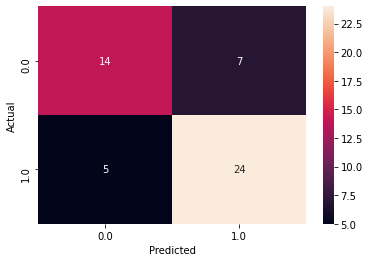

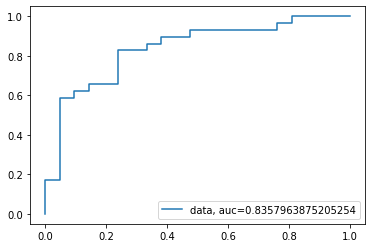



ITERATIVE  IMPUTED DATASET using  ElasticNet
                                    coef  exp_coef
intercept                      -0.000057  0.999943
Gender                          0.000388  1.000388
Symptoms                       -0.002581  0.997423
Hepatitis B Surface Antigen     0.000679  1.000679
Hepatitis B Core Antibody       0.000388  1.000388
Hepatitis C Virus Antibody     -0.001258  0.998742
Endemic Countries               0.000277  1.000277
Smoking                         0.000634  1.000635
Diabetes                       -0.000714  0.999287
Obesity                         0.000769  1.000769
Arterial Hypertension           0.002197  1.002199
Chronic Renal Insufficiency    -0.000056  0.999944
Nonalcoholic Steatohepatitis    0.000000  1.000000
Esophageal Varices              0.000000  1.000000
Splenomegaly                   -0.000660  0.999340
Portal Hypertension            -0.000402  0.999598
Portal Vein Thrombosis         -0.000920  0.999081
Liver Metastasis               -0.0

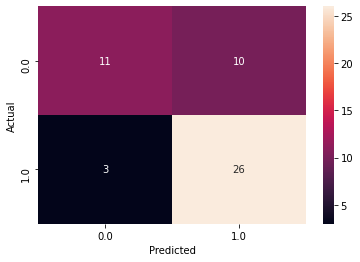

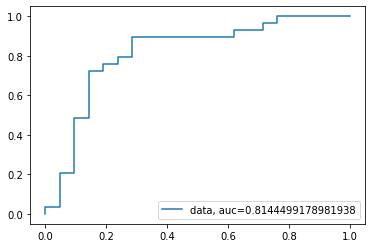

In [8]:
data_list = ['mean', 'mode', 'median', 'iterative']

for data in data_list:
    
    X_train, X_test, y_train, y_test = get_data(data)
    
    X_train, X_test, y_train = feature_selection(X_train, X_test, y_train)
    
    penalties = ['l1', 'l2', 'elasticnet']
    
    for penalty in penalties:
        
        if penalty == 'l1':
            solver = 'liblinear'
            name = 'Lasso'
            l1_ratio = None
        elif penalty == 'l2':
            solver = 'lbfgs'
            name = 'Ridge'
            l1_ratio = None
        elif penalty == 'elasticnet':
            solver='saga'
            name = 'ElasticNet'
            l1_ratio = 0.5

        print('\n')
        print(data.upper(), ' IMPUTED DATASET using ', name)

        ## run logistic regression using sklearn
        logistic = LogisticRegression(penalty=penalty, solver=solver, multi_class='ovr', l1_ratio = l1_ratio)
        logistic = logistic.fit(X_train,y_train)
        y_pred = logistic.predict(X_test)


        # printing
        values = np.append(logistic.intercept_, logistic.coef_)

        # get the names of the values
        names = np.append('intercept', X_train.columns)
        table_ = pd.DataFrame(values, index = names, columns=['coef'])
        table_['exp_coef'] = np.exp(table_['coef'])
        print(table_)

        print('\n')
        print("Accuracy ({}): {:.2f}".format(data, metrics.accuracy_score(y_test, y_pred)))
        print("Precision ({}): {:.2f}".format(data, metrics.precision_score(y_test, y_pred)))
        print("Recall ({}): {:.2f}".format(data, metrics.recall_score(y_test, y_pred)))

        confusion_matrix = pd.crosstab(y_test, y_pred, rownames=['Actual'], colnames=['Predicted'])
        sn.heatmap(confusion_matrix, annot=True)
        plt.show()

        y_pred_proba = logistic.predict_proba(X_test)[::,1]
        fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
        auc = metrics.roc_auc_score(y_test, y_pred_proba)
        plt.plot(fpr,tpr,label="data, auc="+str(auc))
        plt.legend(loc=4)
        plt.show()

        ## save data for comparison
        results = results.append(pd.DataFrame([{"data" : data, 
                        "regularization": name, 
                        "package": "SkLearn", 
                        "accuracy": np.round(metrics.accuracy_score(y_test, y_pred), 2), 
                        "precision": np.round(metrics.precision_score(y_test, y_pred), 2), 
                        "recall": np.round(metrics.recall_score(y_test, y_pred), 2), 
                        "f1": np.round(metrics.f1_score(y_test, y_pred), 2), 
                        "rSquared": np.round(metrics.r2_score(y_test, y_pred), 2), 
                        "AUC": np.round(metrics.roc_auc_score(y_test, y_pred), 2)}]), ignore_index=True)

In [9]:
results_sklearn = results[results.package == 'SkLearn']
final_sklearn = results_sklearn.pivot(index=['data', 'regularization'], columns="package", values=['accuracy', 'precision', 'recall', 'f1', 'rSquared', 'AUC'])
final_sklearn.columns = final_sklearn.columns.swaplevel(0,1)
final_sklearn

package                   SkLearn                                      
                         accuracy precision recall    f1 rSquared   AUC
data      regularization                                               
iterative ElasticNet         0.74      0.72   0.90  0.80    -0.07  0.71
          Lasso              0.74      0.79   0.76  0.77    -0.07  0.74
          Ridge              0.76      0.77   0.83  0.80     0.01  0.75
          default            0.76      0.77   0.83  0.80     0.01  0.75
mean      ElasticNet         0.76      0.74   0.90  0.81     0.01  0.73
          Lasso              0.76      0.79   0.79  0.79     0.01  0.75
          Ridge              0.74      0.75   0.83  0.79    -0.07  0.72
          default            0.74      0.75   0.83  0.79    -0.07  0.72
median    ElasticNet         0.78      0.76   0.90  0.83     0.10  0.76
          Lasso              0.68      0.72   0.72  0.72    -0.31  0.67
          Ridge              0.76      0.79   0.79  0.79     0.01  0.75
          default            0.76      0.79   0.79  0.79     0.01  0.75
mode      ElasticNet         0.68      0.66   0.93  0.77    -0.31  0.63
          Lasso              0.72      0.74   0.79  0.77    -0.15  0.71
          Ridge              0.72      0.73   0.83  0.77    -0.15  0.70
          default            0.72      0.73   0.83  0.77    -0.15  0.70

In [10]:
results_statsmodels = results[results.package == 'StatsModels']
final_statsmodels = results_statsmodels.pivot(index=['data', 'regularization'], columns="package", values=['accuracy', 'precision', 'recall', 'f1', 'rSquared', 'AUC'])
final_statsmodels.columns = final_statsmodels.columns.swaplevel(0,1)
final_statsmodels

package                  StatsModels                                      
                            accuracy precision recall    f1 rSquared   AUC
data      regularization                                                  
iterative Lasso                 0.70      0.71   0.83  0.76     0.68  0.68
          Ridge                 0.70      0.71   0.83  0.76     0.68  0.68
          default               0.70      0.71   0.83  0.76     0.68  0.68
mean      Lasso                 0.72      0.78   0.72  0.75     0.65  0.72
          Ridge                 0.72      0.78   0.72  0.75     0.65  0.72
          default               0.72      0.78   0.72  0.75     0.65  0.72
median    Lasso                 0.64      0.68   0.72  0.70     0.65  0.62
          Ridge                 0.64      0.68   0.72  0.70     0.65  0.62
          default               0.64      0.68   0.72  0.70     0.65  0.62
mode      Lasso                 0.60      0.64   0.72  0.68     0.74  0.58
          Ridge                 0.60      0.64   0.72  0.68     0.74  0.58
          default               0.60      0.64   0.72  0.68     0.74  0.58